In [1]:
NUM = 14

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

# 定义数据集路径
data_folder = 'qmnist/all'
x_data = []
y_data = []

# 加载图像和标签
for label in range(NUM):
    label_folder = os.path.join(data_folder, str(label))
    images = []

    for img_name in os.listdir(label_folder):
        img_path = os.path.join(label_folder, img_name)
        
        # 加载并处理图像
        image = Image.open(img_path).convert('L')  # 转换为灰度图
        image = image.resize((28, 28))  # 调整大小
        image_array = np.array(image)
        images.append(image_array)
    
    x_data.extend(images)
    y_data.extend([label] * len(images))

# 转换为NumPy数组
x_data = np.array(x_data)
y_data = np.array(y_data)

# 直接使用所有样本
x_balanced = x_data
y_balanced = y_data

# 按比例拆分数据集（例如，80% 训练集，20% 测试集）
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)

# 确保数据集的形状符合TensorFlow的要求
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') 
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')

# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        # rotation_range=1,  
        # zoom_range = (0.9, 1),
        # width_shift_range=0.1, 
        # height_shift_range=0.1
)
# 适配数据生成器
datagen.fit(x_train)

# 打印每种图片的数量
unique, counts = np.unique(y_balanced, return_counts=True)
print("每种图片数量:")
for label, count in zip(unique, counts):
    print(f'类别 {label}: {count} 张')


每种图片数量:
类别 0: 11875 张
类别 1: 13533 张
类别 2: 11984 张
类别 3: 12215 张
类别 4: 11622 张
类别 5: 10875 张
类别 6: 11875 张
类别 7: 12496 张
类别 8: 11741 张
类别 9: 11784 张
类别 10: 10118 张
类别 11: 13000 张
类别 12: 10204 张
类别 13: 8468 张


In [3]:
import numpy as np
from keras.datasets import mnist
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, MaxPooling2D, Softmax, Activation, BatchNormalization, Flatten, Dropout, DepthwiseConv2D
from tensorflow.keras.layers import MaxPool2D, AvgPool2D, AveragePooling2D, GlobalAveragePooling2D,ZeroPadding2D,Input,Embedding,PReLU,Reshape
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.utils import to_categorical
import keras.backend as K
import tensorflow as tf
import time
# 
# from os import environ
# environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
# (x_train,y_train), (x_test,y_test) = mnist.load_data() 


In [5]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)/255
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)/255

y_train = to_categorical(y_train,num_classes=NUM) 
y_test = to_categorical(y_test,num_classes=NUM)

In [6]:
def init_model(dim0):
    model = Sequential()

    # 第一个卷积层
    model.add(Conv2D(dim0 * 8, (3, 3), padding='same', strides=(2, 2),
                     input_shape=(28, 28, 1), name='ftr0a'))
    model.add(BatchNormalization(name="bn0"))
    model.add(Activation('relu', name="relu0"))
    model.add(Dropout(0.3))  # 添加 Dropout 层


    # # 第一个深度可分离卷积层
    # model.add(DepthwiseConv2D((3, 3), padding='same', name='ftr0b'))
    # model.add(BatchNormalization())
    # model.add(Activation('relu', name="relu00"))
    # model.add(Dropout(0.3))  # 添加 Dropout 层


    # 第二个卷积层
    model.add(Conv2D(dim0 * 4, (3, 3), padding='same', strides=(2, 2), name='ftr1a'))
    model.add(BatchNormalization(name="bn1"))
    model.add(Activation('relu', name="relu1"))

    # # 第二个深度可分离卷积层
    # model.add(DepthwiseConv2D((3, 3), padding='same', depth_multiplier=2, name='ftr1b'))
    # model.add(BatchNormalization())
    # model.add(Activation('relu', name="relu11"))
    # model.add(Dropout(0.3))  # 添加 Dropout 层

    # # 全局平均池化层
    # model.add(GlobalAveragePooling2D(name='GAP'))
    # model.add(Dropout(0.3))  # 添加 Dropout 层

    model.add(Flatten())

    # 全连接层
    model.add(Dense(16, name="fc1"))
    model.add(Activation('softmax', name="sm1"))
    model.add(Dropout(0.3))  # 添加 Dropout 层

    # 全连接层
    model.add(Dense(NUM, name="fc2"))
    model.add(Dropout(0.3))  # 添加 Dropout 层
    model.add(Activation('softmax', name="sm2"))

    return model

# 设置参数并初始化模型
DIM0 = 3
model = init_model(DIM0)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ftr0a (Conv2D)              (None, 14, 14, 24)        240       
                                                                 
 bn0 (BatchNormalization)    (None, 14, 14, 24)        96        
                                                                 
 relu0 (Activation)          (None, 14, 14, 24)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 24)        0         
                                                                 
 ftr1a (Conv2D)              (None, 7, 7, 12)          2604      
                                                                 
 bn1 (BatchNormalization)    (None, 7, 7, 12)          48        
                                                                 
 relu1 (Activation)          (None, 7, 7, 12)          0

In [7]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
# 
# def init_model(dim0):
#     model = Sequential()
# 
#     # 第一个卷积层
#     model.add(Conv2D(dim0 * 8, (3, 3), padding='same', strides=(2, 2), input_shape=(28, 28, 1), name='ftr0a'))
#     model.add(BatchNormalization(name="bn0"))
#     model.add(Activation('relu', name="relu0"))
#     model.add(Dropout(0.3))
# 
#     # 第二个卷积层
#     model.add(Conv2D(dim0 * 4, (3, 3), padding='same', strides=(2, 2), name='ftr1a'))
#     model.add(BatchNormalization(name="bn1"))
#     model.add(Activation('relu', name="relu1"))
# 
#     # 全局平均池化层
#     model.add(GlobalAveragePooling2D(name='GAP'))
#     model.add(Dropout(0.3))
# 
#     # 全连接层
#     model.add(Dense(64, name="fc1"))
#     model.add(Activation('relu', name="relu_fc1"))
#     model.add(Dropout(0.3))
# 
#     # 输出层
#     model.add(Dense(NUM, name="fc2"))
#     model.add(Activation('softmax', name="sm2"))
# 
#     return model
# 
# # 设置参数并初始化模型
# DIM0 = 3
# model = init_model(DIM0)
# model.summary()


Epoch 1/30
1012/1012 - 17s - loss: 2.0757 - categorical_accuracy: 0.3196 - val_loss: 1.5533 - val_categorical_accuracy: 0.5550 - 17s/epoch - 17ms/step
Epoch 2/30


E:\ai-arithmetic\ai-arithmetic\train\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1012/1012 - 15s - loss: 1.7438 - categorical_accuracy: 0.3779 - val_loss: 1.2157 - val_categorical_accuracy: 0.5938 - 15s/epoch - 15ms/step
Epoch 3/30
1012/1012 - 17s - loss: 1.6588 - categorical_accuracy: 0.3956 - val_loss: 1.0302 - val_categorical_accuracy: 0.6661 - 17s/epoch - 17ms/step
Epoch 4/30
1012/1012 - 17s - loss: 1.5695 - categorical_accuracy: 0.4246 - val_loss: 0.8360 - val_categorical_accuracy: 0.7407 - 17s/epoch - 17ms/step
Epoch 5/30
1012/1012 - 17s - loss: 1.5025 - categorical_accuracy: 0.4423 - val_loss: 0.7358 - val_categorical_accuracy: 0.7422 - 17s/epoch - 17ms/step
Epoch 6/30
1012/1012 - 16s - loss: 1.4272 - categorical_accuracy: 0.4850 - val_loss: 0.5738 - val_categorical_accuracy: 0.8554 - 16s/epoch - 15ms/step
Epoch 7/30
1012/1012 - 15s - loss: 1.2894 - categorical_accuracy: 0.5428 - val_loss: 0.4024 - val_categorical_accuracy: 0.9736 - 15s/epoch - 15ms/step
Epoch 8/30
1012/1012 - 15s - loss: 1.2228 - categorical_accuracy: 0.5624 - val_loss: 0.3063 - val_categor

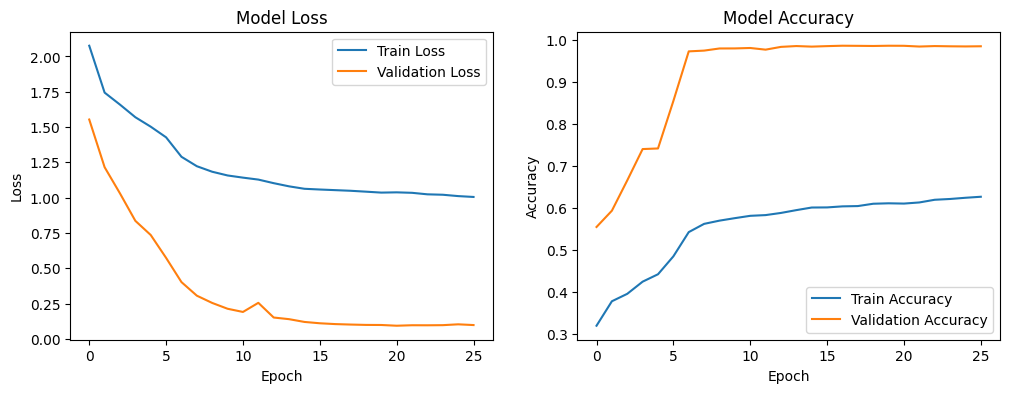

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 编译模型
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["categorical_accuracy"])

# 创建数据增强生成器
train_generator = datagen.flow(x_train, y_train, batch_size=128)

# 定义早停回调
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# 定义模型检查点回调，保存验证损失最小的模型
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

# 使用数据生成器进行训练，并获取 History 对象
history = model.fit(train_generator,
                    batch_size=128,
                    epochs=30,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle=True)

# 加载最佳模型权重
model.load_weights('best_model.h5')

# 绘制训练和验证的损失和准确率曲线
def plot_training_history(history):
    # 绘制训练 & 验证损失值
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # 绘制训练 & 验证准确率值
    plt.subplot(1, 2, 2)
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.show()

plot_training_history(history)


In [9]:

# 评估模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\n测试集的总体准确率: {test_acc:.2f}')

# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算每种类别的错误率
error_rates = {}
for label in range(NUM):
    label_indices = np.where(y_test_classes == label)[0]
    label_correct = np.sum(y_pred_classes[label_indices] == y_test_classes[label_indices])
    label_total = len(label_indices)
    label_error_rate = 1 - (label_correct / label_total)
    error_rates[label] = label_error_rate

print("\n每种类别的错误率:")
for label, error_rate in error_rates.items():
    print(f'类别 {label}: {error_rate:.2f}')
    

1012/1012 [==============================] - 3s 3ms/step - loss: 0.0936 - categorical_accuracy: 0.9869

测试集的总体准确率: 0.99
1012/1012 [==============================] - 2s 2ms/step

每种类别的错误率:
类别 0: 0.01
类别 1: 0.01
类别 2: 0.03
类别 3: 0.01
类别 4: 0.02
类别 5: 0.01
类别 6: 0.01
类别 7: 0.01
类别 8: 0.02
类别 9: 0.02
类别 10: 0.02
类别 11: 0.00
类别 12: 0.00
类别 13: 0.01


In [10]:
# 导出模型
model.save("mnist.h5")
model.export("mnist")
# 调用转换脚本
!python tools/h5_to_tflite.py mnist mnist.tflite 1 qmnist/all 0to1
!python tools/tflite2tmdl.py mnist.tflite mnist.tmdl int8 1 28,28,1 14 1

INFO:tensorflow:Assets written to: mnist\assets


INFO:tensorflow:Assets written to: mnist\assets


Saved artifact at 'mnist'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 28, 28, 1)
  Returns:
    float32 Tensor, shape=(None, 14)
Done, quant used time:3.024524450302124


2024-11-09 16:37:09.503053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Use `tf.saved_model.load` instead.
2024-11-09 16:37:09.548694: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-11-09 16:37:09.682556: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-11-09 16:37:09.682674: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for 

CONV_2D
{'dilation_h_factor': 1, 'dilation_w_factor': 1, 'fused_activation_function': 1, 'padding': 0, 'stride_h': 2, 'stride_w': 2}
    input: serving_default_ftr0a_input
    output: sequential/relu0/Relu;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential/relu0/Relu;sequential/bn0/FusedBatchNormV3;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential/bn0/FusedBatchNormV3;ftr0a/bias;sequential/ftr0a/BiasAdd;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential/ftr0a/BiasAdd;sequential/ftr0a/Conv2D;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential/ftr0a/Conv2D1
    filter 9: sequential/ftr0a/Conv2D;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential/ftr0a/Conv2D 
    bias 8: sequential/relu0/Relu;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential/relu0/Relu;sequential/bn0/FusedBatchNormV3;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential/bn0/FusedBatchNormV3;ftr0a/bias;sequential/ftr0a/BiasAdd;StatefulPartitionedCall_1/Sta

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
